# Classificando cães 🐕 e gatos 🐈

Você já imaginou criar uma rede neural para classificar imagens? As redes neurais convolucionais (CNNs) são amplamente utilizadas em uma variedade de aplicações de visão computacional e processamento de imagens devido à sua capacidade de aprender representações hierárquicas de dados.

Na aula de hoje vamos criar uma rede neural para classificar cães e gatos. Sabemos que para os olhos humanos é fácil a identificação dos animais por meio de algumas diferenças entre ambos, tal como gatos possuem os olhos mais puxadinhos, orelhinhas mais pontudas e entre outras características. Mas também sabemos que temos cães que podem ter características semelhantes ao gato, tal como a orelhinha pontuda, cauda longa, e entre outras características. Será que a rede neural consegue distinguir os animais? Vamos codar e descobrir juntos!!

## Sobre a base de dados

Essa base de dados está disponível no Kaggle, lá é possível encontrar diversas bases para trabalhar com dados de visão computacional! Para nossa aula de hoje, selecionei essa base de gatinhos e cachorrinhos fofos!

Link: https://www.kaggle.com/datasets/moazeldsokyx/dogs-vs-cats

## Importando as bibliotecas que vamos utilizar na aula de hoje:

In [3]:
# Blibliotecas essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import cv2

# Para Deep Learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

# Para validação do modelo
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
# Montando ambiente do google

from google.colab import drive
drive.mount('/content/drive')

import os
caminho_da_pasta = "/content/drive/My Drive/cat_dog_images"
pasta_imagens = Path(caminho_da_pasta)

Mounted at /content/drive


Depois de importar as bibliotecas necessárias para realizar nosso projeto, vamos utilizar o glob para listar as imagens que possuem o padrão ".jpg" (que no caso são imagens de cachorrinhos e gatinhos que estão aqui na pasta do drive).

In [5]:
# Listando toas as imagens do diretório
filepaths = list(pasta_imagens.glob(r'**/*.jpg'))
filepaths

[PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.0.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.105.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.102.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.1.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.103.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.100.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.106.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.1000.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.104.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.101.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.112.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.114.jpg'),
 PosixPath('/content/drive/My Drive/cat_dog_images/gatinhos/cat.113.jpg'),
 PosixPath('/content/drive/M

## Tratando os dados

Como próximo passo, vamos armazenar as **targets** do nosso modelo e as **imagens** em uma **lista**. Para todas as imagens localizadas em filepaths, vamos percorrer com um **loop cada uma das imagens e realizar algumas tratativas** como por exemplo redimensionar a imagem e normalizar o intervalo de pixel para ficar entre 0 e 1 e armazena-la nas listas.

Aqui é importante relembrar que redes neurais funcionam melhor quando estão com os dados normalizados ou padronizados.

In [6]:
# Iniciando rótulos e listas de imagens para armazenar os dados
labels = [] # armazenando as variáveis target
images = [] # armazenando imagens

# Definindo o tamanho da dimensão da imagem
image_size = 64

# Um loop for para definir as variáveis x e y para os modelos
for filepath in filepaths:
  # Divide o nome do caminho para extrair o cabeçalho do caminho com split
  head = os.path.split(filepath)
  # Divide o cabeçalho do caminho anterior para extrair o nome do animal
  animal = os.path.split(head[0])
  # Armazena o nome do animal na lista de labels
  labels.append(animal[1])
  # Obtem a imagem do caminho com cv2
  img = cv2.imread(str(filepath))
  # Redimensiona a imagem e normalize o intervalo de pixels para ficar entre 0 e 1(padronização)
  # Utilizando float32 para criar uma precisão limitada (menor demanda de memória em comparação com tipos de ponto flutuante de maior precisão: float64)
  img = cv2.resize(img, (image_size, image_size)).astype('float32') / 255.0
  # Adiciona a imagem na lista de imagens
  images.append(img)

# Converte a imagem em lista de array
images = np.array(images)
# Converte as labels para lista de array
labels = np.array(labels)

Muito bem! Agora temos as imagens armazenadas em um formato de um grande array na variável "images" e os rótulos em "labels".

In [7]:
images.shape

(1605, 64, 64, 3)

* 807 amostras (gatinhos e cachorrinhos)
* 64x64 (dimensão)
* 3 (número de matrizes que compõe a imagem (RGB))  

In [8]:
images

array([[[[0.3529412 , 0.654902  , 0.80784315],
         [0.3764706 , 0.6784314 , 0.83137256],
         [0.39607844, 0.7019608 , 0.87058824],
         ...,
         [0.5411765 , 0.84313726, 0.972549  ],
         [0.5019608 , 0.81960785, 0.96862745],
         [0.47843137, 0.8       , 0.9529412 ]],

        [[0.3529412 , 0.654902  , 0.80784315],
         [0.3764706 , 0.6784314 , 0.83137256],
         [0.39607844, 0.7019608 , 0.87058824],
         ...,
         [0.5568628 , 0.85490197, 0.96862745],
         [0.5254902 , 0.83137256, 0.96862745],
         [0.49411765, 0.80784315, 0.95686275]],

        [[0.3529412 , 0.654902  , 0.80784315],
         [0.3764706 , 0.6784314 , 0.83137256],
         [0.39607844, 0.7019608 , 0.87058824],
         ...,
         [0.5686275 , 0.8509804 , 0.96862745],
         [0.5529412 , 0.84705883, 0.96862745],
         [0.5137255 , 0.81960785, 0.96862745]],

        ...,

        [[0.22352941, 0.5019608 , 0.63529414],
         [0.23921569, 0.5176471 , 0.6509804 ]

In [9]:
labels

array(['gatinhos', 'gatinhos', 'gatinhos', ..., 'cachorrinhos',
       'cachorrinhos', 'cachorrinhos'], dtype='<U12')

## Construindo um dataframe

Com as imagens e rótulos já definidos, vamos contruir um dataframe com o nome e o rótulo da imagem.

In [10]:
# Salvando a lista de caminhos de arquivo
pd_filepaths = pd.Series(filepaths, name='Filepath').astype(str)

In [11]:
# Visualizando o caminho das imagens
print(pd_filepaths[:3])

0    /content/drive/My Drive/cat_dog_images/gatinho...
1    /content/drive/My Drive/cat_dog_images/gatinho...
2    /content/drive/My Drive/cat_dog_images/gatinho...
Name: Filepath, dtype: object


In [12]:
# Visualizando os rótulos das imagens
print(labels[:3])

['gatinhos' 'gatinhos' 'gatinhos']


In [13]:
# Adionando a label
pd_labels = pd.Series(labels, name='Label')

In [14]:
pd_labels

,Label
0,gatinhos
1,gatinhos
2,gatinhos
3,gatinhos
4,gatinhos
...,...
1600,cachorrinhos
1601,cachorrinhos
1602,cachorrinhos
1603,cachorrinhos


In [15]:
# Concatenando o filepaths e labels
df = pd.concat([pd_filepaths, pd_labels], axis=1)

In [16]:
df.head()

,Filepath,Label
0,/content/drive/My Drive/cat_dog_images/gatinho...,gatinhos
1,/content/drive/My Drive/cat_dog_images/gatinho...,gatinhos
2,/content/drive/My Drive/cat_dog_images/gatinho...,gatinhos
3,/content/drive/My Drive/cat_dog_images/gatinho...,gatinhos
4,/content/drive/My Drive/cat_dog_images/gatinho...,gatinhos


In [17]:
df.tail()

,Filepath,Label
1600,/content/drive/My Drive/cat_dog_images/cachorr...,cachorrinhos
1601,/content/drive/My Drive/cat_dog_images/cachorr...,cachorrinhos
1602,/content/drive/My Drive/cat_dog_images/cachorr...,cachorrinhos
1603,/content/drive/My Drive/cat_dog_images/cachorr...,cachorrinhos
1604,/content/drive/My Drive/cat_dog_images/cachorr...,cachorrinhos


Perceba que nossos dados estão em ordem das classes, isso pode ser um problema para o modelo, então vamos utilizar o sample para embaralhar o dataframe:

In [18]:
# Embaralhando o dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [19]:
df.head()

,Filepath,Label
0,/content/drive/My Drive/cat_dog_images/cachorr...,cachorrinhos
1,/content/drive/My Drive/cat_dog_images/gatinho...,gatinhos
2,/content/drive/My Drive/cat_dog_images/gatinho...,gatinhos
3,/content/drive/My Drive/cat_dog_images/cachorr...,cachorrinhos
4,/content/drive/My Drive/cat_dog_images/gatinho...,gatinhos


In [20]:
# Cria uma cópia do dataframe com apenas uma imagem de cada animal

# o subset está procurando por duplicatas apenas na coluna chamada 'Label' e removendo todas as duplicatas encontradas.
df_singles = df.copy().drop_duplicates(subset=('Label')).reset_index()

In [21]:
len(df_singles)

2

In [22]:
# Define o número de classes
num_classes = df_singles.shape[0]

Show! Agora que temos as classes mapeadas na variável num_classes, vamos visualizar duas amostras de imagens dentro do dataset:

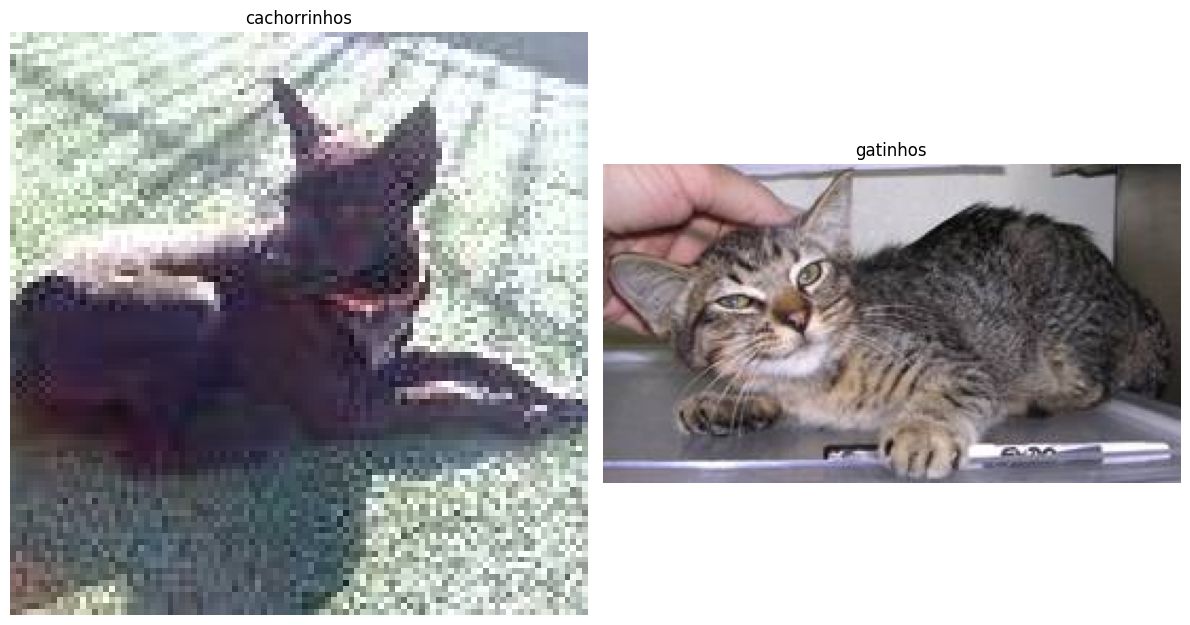

In [23]:
# Configura o número de linhas e colunas para vizualizar os dados no plot
ROW = 1
COLUMN = 2

# Dimensões das imagens
plt.figure(figsize=(12, 9))
# Loop para cada animal
for i in range(num_classes):
  # Defina uma variável de imagem local para i imagem no dataframe de singles
  image = df_singles.Filepath[i]
  # Define a posição da imagem a ser plotada
  plt.subplot(ROW, COLUMN, i+1)
  # Mostra a imagem
  plt.imshow(plt.imread(image))
  # Adiciona o rótulo do bichinho que corresponde à imagem
  plt.title('{}'.format(df_singles.Label[i]))
  # Desliga o eixo de plotagem
  plt.axis('off')
  # Faça com que o preenchimento ao redor das imagens seja mínimo
  plt.tight_layout()
plt.show()

## Separando em treino e teste a base de dados

Agora com as imagens e classes organizados, podemos aplicar o train_test_split para separar as bases de treinamento e teste:

In [24]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=44)

In [25]:
# Analisando a dimensão dos dados
x_train.shape

(1284, 64, 64, 3)

In [26]:
x_test.shape

(321, 64, 64, 3)

In [27]:
images

array([[[[0.3529412 , 0.654902  , 0.80784315],
         [0.3764706 , 0.6784314 , 0.83137256],
         [0.39607844, 0.7019608 , 0.87058824],
         ...,
         [0.5411765 , 0.84313726, 0.972549  ],
         [0.5019608 , 0.81960785, 0.96862745],
         [0.47843137, 0.8       , 0.9529412 ]],

        [[0.3529412 , 0.654902  , 0.80784315],
         [0.3764706 , 0.6784314 , 0.83137256],
         [0.39607844, 0.7019608 , 0.87058824],
         ...,
         [0.5568628 , 0.85490197, 0.96862745],
         [0.5254902 , 0.83137256, 0.96862745],
         [0.49411765, 0.80784315, 0.95686275]],

        [[0.3529412 , 0.654902  , 0.80784315],
         [0.3764706 , 0.6784314 , 0.83137256],
         [0.39607844, 0.7019608 , 0.87058824],
         ...,
         [0.5686275 , 0.8509804 , 0.96862745],
         [0.5529412 , 0.84705883, 0.96862745],
         [0.5137255 , 0.81960785, 0.96862745]],

        ...,

        [[0.22352941, 0.5019608 , 0.63529414],
         [0.23921569, 0.5176471 , 0.6509804 ]

Sabemos que as imagens são basicamente uma matriz de pixels e para colocar as imagens dentro da arquitetura das redes convolucionais, é preciso "achatar" essas matrizes multidimensionais em vetores unidimensionais. Uma das camadas da rede, a Flatten(), é uma das partes da rede que achata os dados antes de entrar nas camadas densas.

In [28]:
# Achatar os dados de teste e treinamento
x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3])
x_test_flat = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3])

In [29]:
# Visualizando a transformação
x_train_flat.shape

(1284, 12288)

Como próximo passo, vamos converter as classes de texto em binárias. Para esse procedimento, vamos utilizar o método LabelEncoder().

In [30]:
# Converter Strings em Numéricos
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Converter um vetor de classe (inteiros) em uma matriz de classe categórica
y_train_tf = keras.utils.to_categorical(y_train, num_classes)
y_test_tf = keras.utils.to_categorical(y_test, num_classes)

Vamos configurar agora como próximo passo o ModelCheckpoint para usar os melhores pesos para este modelo. Um dos benefícios do ModelCheckpoint é salvar uma cópia do modelo em disco em intervalos regulares (como após cada época de processamento) para que você possa retomar o treinamento a partir do ponto em que parou, minimizando perdas de tempo e recursos computacionais.

In [31]:
from distutils.file_util import copy_file

# Define um objeto ModelCheckpoint para usar os melhores pesos para este modelo

# versão chatGPT
checkpointer = ModelCheckpoint(filepath="weights.best.keras", verbose=0, save_best_only=True) # save best model


# versão do curso - não funciona atualmente por causa da versão atual do keras
# checkpointer = ModelCheckpoint(filepath="weights.best.hdf5", verbose=0, save_best_only=True) # save best model

Como próximo passo, vamos definir a entrada da rede e armazenar na variável

**input_shape** e em seguida configurar a learning rate e a queda do peso do otimizador com **weight_decay**.

O argumento weight_decay é usado para aplicar **regularização L2** (também conhecida como regularização de peso) às camadas densas (fully connected) de uma rede neural durante o treinamento. A regularização L2 funciona adicionando um termo à função de perda durante o treinamento que penaliza os pesos maiores.

In [32]:
# Define a forma de entrada das imagens passadas pelo modelo
input_shape = (image_size, image_size, 3)

# Define a taxa de aprendizado e a queda de peso para o otimizador usar
learning_rate = 0.001

Agora chegou o momento tão esperado, nossa rede neural convolucional!

Acompanhe comigo o código a seguir e vamos comentando sobre cada passo da contrução da rede:

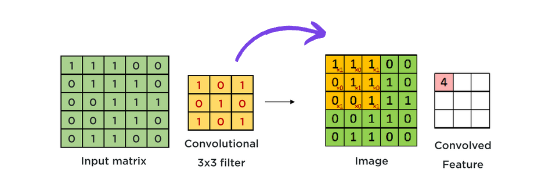

In [33]:
tf.random.set_seed(42) # Definindo uma semente aleatória para utilizar sempre os mesmos dados durante nossos testes

model = Sequential() # Abrindo a sequencia do modelo

# 1 camada convolucional com 128 neurônios | filtro utilizando uma matriz 3x3 sendo movimentado por um stride de 2
# padding ativado (com bordas de zeros) | função de ativação ReLU | regularização L2 ativada
model.add(Conv2D(128,
                 kernel_size=(3,3),
                 strides=(2,2),
                 padding='same',
                 activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 input_shape=input_shape)),

# Camada de MaxPolling ativada, com uma matriz 2x2. Padding ativado
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same'))

# Regularização de dropout ativada
model.add(Dropout(0.2))

# 2 camada convolucional com 92 neurônios | filtro utilizando uma matriz 3x3 sendo movimentado por um stride de 2
# padding ativado (com bordas de zeros) | função de ativação ReLU | regularização L2 ativada
model.add(Conv2D(92,
                 kernel_size=(3,3),
                 strides=(2,2),
                 padding='same',
                 activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001))),

# Camada de MaxPooling ativada, com uma matriz 2x2. Padding ativado
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same'))

# Regularização de dropout ativada
model.add(Dropout(0.2))

# Camada que achata os dados da imagem
model.add(Flatten())
# Camada Dense da rede neural convolucional + função de ativação ReLU
model.add(Dense(256, activation='relu'))
# Camada de saída da rede, utilizando a função de ativação softmax para criar a probabilidade de pertecimento das classes
# model.add(Dense(y_train_tf.shape[1], activation='softmax'))
# Camada de saída da rede, utilizando a função de ativação sigmoid para classificação binária
model.add(Dense(y_train_tf.shape[1], activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Agora vamos configurar uma técnica de validação do modelo para evitar que as épocas de processamento não executem o modelo sem ter melhoras significativas, o **early stopping**. Essa técnica monitora a perda no conjunto de validação e interrompe o treinamento se a perda não diminuir significativamente por um número especificado de épocas (10 no exemplo) após uma pequena melhoria (mínimo delta de 1e-5). Essa é uma **técnica útil para evitar o overfitting e economizar tempo de treinamento**. (Podemos dizer que essa técnica ajuda o modelo a não ficar "estagnado", ou seja, se encontra em estado estacionário).

Além da configuração do early stopping, vamos configurar a função de custo com o **Adam**. A função de custo tem o papel de **ajustar os pesos de uma rede neural durante o treinamento**. o Adam também utiliza um termo de momentum para acelerar o processo de aprendizado. O momentum **ajuda o algoritmo a superar regiões planas ou mínimos locais rasos**, permitindo que ele "ganhe velocidade" na direção do mínimo global. O otimizador Adam requer menos configuração de hiperparâmetro da taxa de aprendizagem, então um valor padrão n = 0,001 pode ser uma boa opção!

Lembrando que a **taxa de aprendizagem** (learning rate) é responsável por controlar o tamanho dos “passos” das interações para encontrar um melhor mínimo local (menor erro). Uma taxa de aprendizagem baixa pode ser mais precisa, porém pode demorar para encontrar o mínimo local. Uma taxa de aprendizado alta pode deixar passar o melhor mínimo local.

In [34]:
# Monitor para interromper o modelo antecipadamente quando a melhoria da perda de validação for mínima
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=1, mode='auto') # Aqui utilizando early stopp

# Compilando o modelo e aplicação a função de custo Adam (utilizando a learning rate que configuramos anteriormente)
# model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

# binary_crossentropy - trabalha melhor com o sigmoid
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

# Salve os dados do modelo em um arquivo h5
model.save('./cat_dog.h5')
# Resumo do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 92)            │         106,076 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 92)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 92)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         377,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 487,262 (1.86 MB)

 Trainable params: 487,262 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Por fim, vamos configurar o número de épocas de processamento em conjunto com a base de validação das épocas. Nesse momento também é importante configurar o número de batchs que o modelo irá processar por épocas para atualizar os pesos. Em outras palavras, as batchs são as quantidades de dados de treinamento que são processadas de uma só vez antes que os pesos do modelo sejam atualizados com base nos gradientes calculados.

In [35]:
# Treinando o modelo
history = model.fit(x_train, y_train_tf, validation_split=0.25, callbacks=[monitor, checkpointer],
                    verbose=1, epochs=45, batch_size=50, shuffle=True)

Epoch 1/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.4835 - loss: 0.8113 - val_accuracy: 0.5109 - val_loss: 0.7682
Epoch 2/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.4944 - loss: 0.7614 - val_accuracy: 0.5265 - val_loss: 0.7424
Epoch 3/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.5207 - loss: 0.7400 - val_accuracy: 0.5389 - val_loss: 0.7265
Epoch 4/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.5469 - loss: 0.7226 - val_accuracy: 0.4984 - val_loss: 0.7559
Epoch 5/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.5230 - loss: 0.7374 - val_accuracy: 0.6012 - val_loss: 0.7091
Epoch 6/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.5447 - loss: 0.7097 - val_accuracy: 0.5327 - val_loss: 0.7211
Epoch 7/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.5714 - loss: 0.7131 - val_accuracy: 0.6012 - val_loss: 0.6896
Epoch 8/45
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.6074 - loss: 0.6868 - val_accuracy: 0.

## Validação do modelo

Existem duas métricas importantes que devemos analisar após executar a rede neural, o valor do erro observado e o valor de acurácia por épocas de processamento. Uma boa prática é analisarmos com gráficos de linhas para identidicarmos as tedências da perfomance da rede.

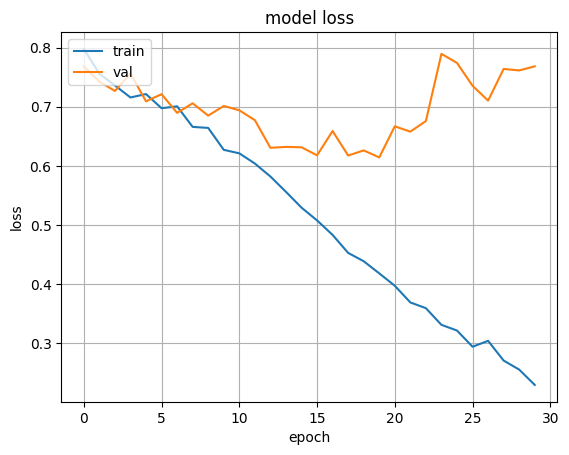

In [36]:
# Validação o erro por épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

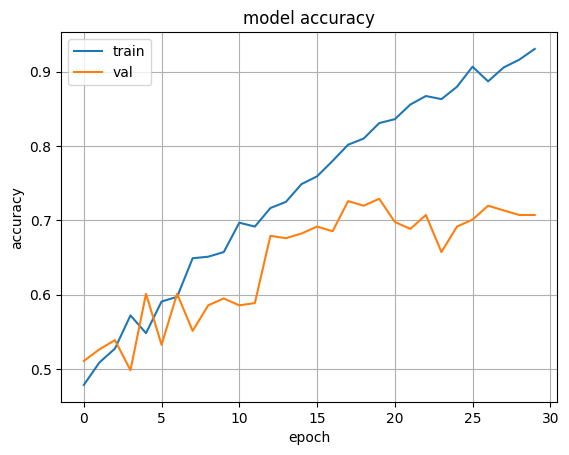

In [37]:
# Validação da acurácia por épocas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

Show! Agora vamos armazenar as predições da base de teste na variável de predição **cnn_pred_cat_dog**:

In [38]:
# Armazena as predições do modelo dos dados de teste em uma variável
cnn_pred_cat_dog = model.predict(x_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Em seguida, vamos utilizar o argmax do numppy para encontrar a classe com a maior probabilidade prevista para cada amostra. (Lembrando que utilizamos a softmax).

In [39]:
# Define o índice do valor máximo de previsão para uma variável
# O valor máximo indica o caractere de previsão do modelo que a imagem representa
cnn_pred_cat_dog = np.argmax(cnn_pred_cat_dog, axis=1)

# Define uma variável para armazenar o rótulo que representa o resultado verdadeiro
y_true = np.argmax(y_test_tf, axis=1)

Agora vamos organizar os nomes dos animais (gatinhos e cachorrinhos) em uma variável, a fim de criar uma lista única de nomes de animais, ordenados alfabeticamente. Vamos também remover duplicatas e ordenar os nomes em ordem alfabética, resultando em uma lista única, limpa e ordenada de nomes de animais.

In [40]:
# Cria um array de nomes de caracteres igual ao array de labels
animal_names = labels
# Reduza os nomes dos animais para apenas valores dict únicos
animal_names = list(dict.fromkeys(animal_names))
# Ordena os caracteres em ordem alfabética, qual é a ordem em que os dados são alimentados
animal_names = sorted(animal_names)

Importante analisar o escopo das classes, então vamos utilizar o classification_report e analisar os resultados por escopo das variáveis targets.

In [42]:
# Criando uma matriz de confusão
cnn_cm_cat_dog = metrics.confusion_matrix(y_true, cnn_pred_cat_dog)

# Definindo a acurácia
cnn_accuracy_cat_dog = metrics.accuracy_score(y_true, cnn_pred_cat_dog)

# Print do Classification report
print(metrics.classification_report(y_true, cnn_pred_cat_dog, target_names=animal_names))
# Print da acurácia
print('Accuracy score: {}'.format(cnn_accuracy_cat_dog))

              precision    recall  f1-score   support

cachorrinhos       0.70      0.80      0.75       160
    gatinhos       0.77      0.66      0.71       161

    accuracy                           0.73       321
   macro avg       0.73      0.73      0.73       321
weighted avg       0.73      0.73      0.73       321

Accuracy score: 0.7289719626168224


Por fim, vamos criar uma função para adivinhar os animaizinhos?

In [43]:
# Função para adivinhar o animal
def guess_animal(filepath):
  # Convete o caminho do arquivo para uma imagem
  image = cv2.imread(filepath)
  # Redimensione a imagem e normalize o intervalo de pixels para ficar entre 0 e 1
  img = cv2.resize(image, (image_size, image_size)).astype('float32') / 255.0
  # Expandir a forma do array de imagens
  img = np.expand_dims(img, axis=0)
  # Usando o modelo para prever o animal que representa a imagem
  pred = model.predict(img)
  # Definindo uma variável para armazenar o índice que representa o caractere que representa a imagem
  classes = np.argmax(pred, axis=1)
  # Print no nome do animal previsto
  print(animal_names[classes[0]])
  # Plote a imagem do animal
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  # Desliga o eixo de plotagem
  plt.axis('off')

## Testando o modelo!!🐱🐶

Chegou o momento de validarmos se essa rede neural consegue realmente identificar novas imagens de cachorros e gatos.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
gatinhos


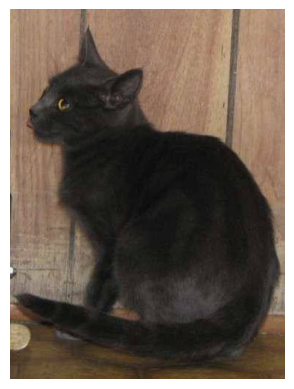

In [44]:
guess_animal('/content/drive/My Drive/teste imagens caes e gatos/cat.10014.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
cachorrinhos


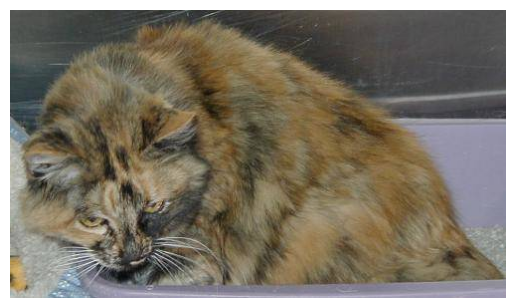

In [48]:
guess_animal('/content/drive/My Drive/teste imagens caes e gatos/cat.9338.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
gatinhos


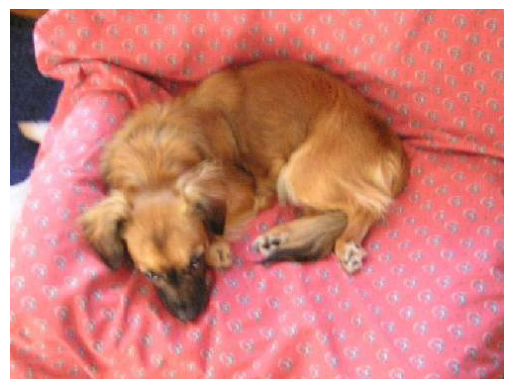

In [49]:
guess_animal('/content/drive/My Drive/teste imagens caes e gatos/dog.9800.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
cachorrinhos


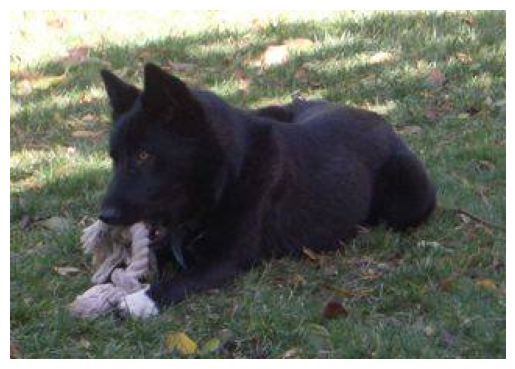

In [47]:
guess_animal('/content/drive/My Drive/teste imagens caes e gatos/dog.7394.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
cachorrinhos


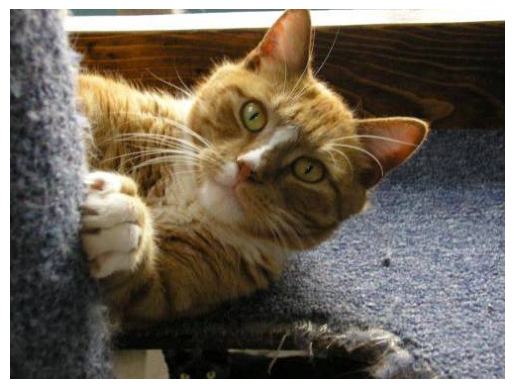

In [52]:
guess_animal('/content/drive/My Drive/teste imagens caes e gatos/cat.10862.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
cachorrinhos


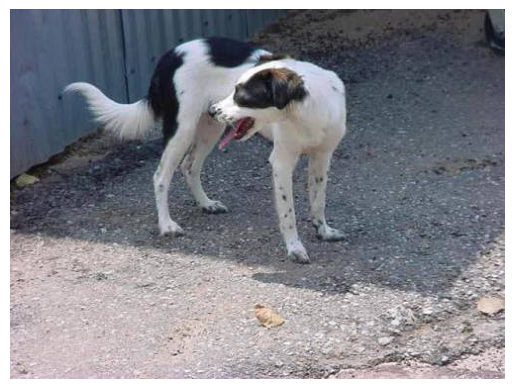

In [51]:
guess_animal('/content/drive/My Drive/teste imagens caes e gatos/dog.4538.jpg')